<a href="https://colab.research.google.com/github/prasanna-venkatesh-m/RNN-Basics/blob/main/Multioutput_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [135]:
data = pd.read_excel('/content/OD.xlsx')

In [136]:
data.head()

,DATE,TotalCountOfAccounts,TotalPrincipalOutstanding,TotalInterestOutstanding,TotalPrincipalOverdue,TotalInterestOverdue,TotalPAR
0,2023-03-31,9764,114244001,12599309,106626416,12075214,114244001
1,2024-01-31,17022,229398872,23777841,162160900,17562565,229398872
2,2024-02-01,17079,230141643,23806354,162706068,17618630,230141643
3,2024-02-02,17127,230537945,23811686,163133198,17648608,230537945
4,2024-02-05,17277,233776331,24281177,163690742,17728246,233776331


In [137]:
data.mean()

,0
DATE,2024-12-13 22:52:06.129665792
TotalCountOfAccounts,56677.579568
TotalPrincipalOutstanding,1098708005.779961
TotalInterestOutstanding,149121446.48723
TotalPrincipalOverdue,579106856.510805
TotalInterestOverdue,81948037.27112
TotalPAR,1098708005.779961


In [138]:
data.max()

,0
DATE,2025-10-24 00:00:00
TotalCountOfAccounts,89073
TotalPrincipalOutstanding,2007274187
TotalInterestOutstanding,314919973
TotalPrincipalOverdue,1138146224
TotalInterestOverdue,187342764
TotalPAR,2007274187


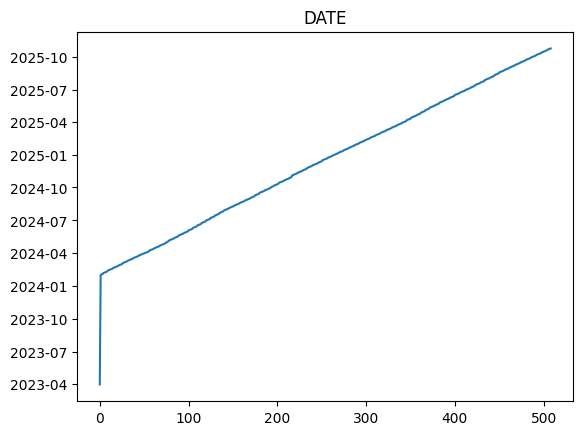

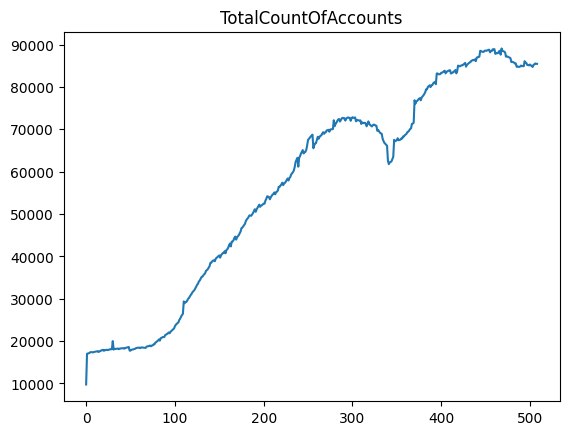

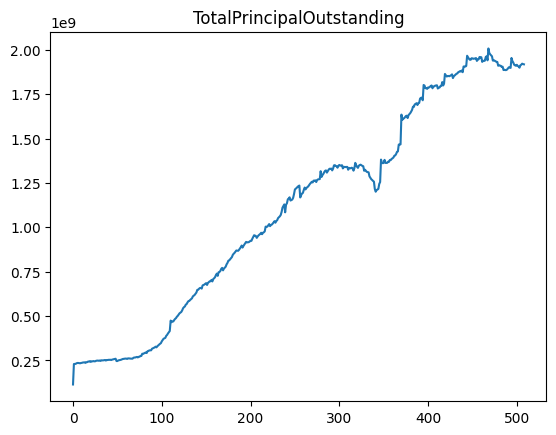

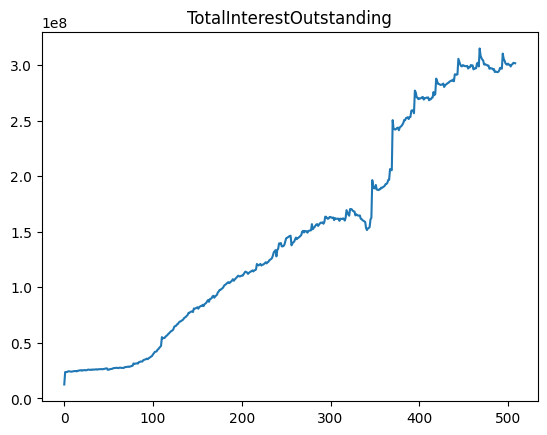

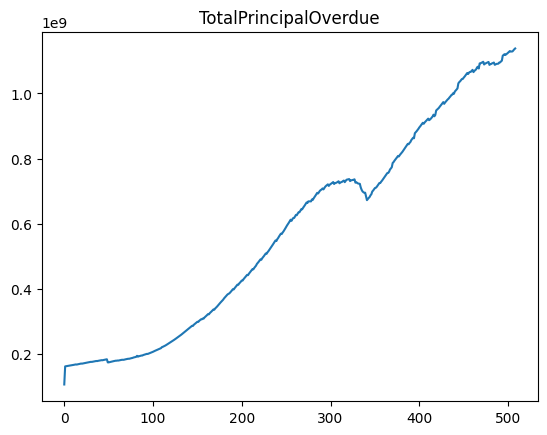

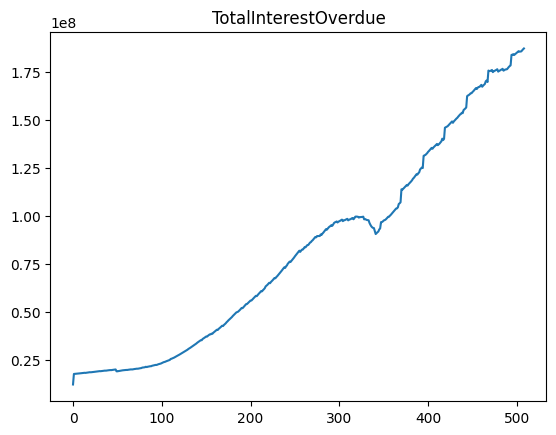

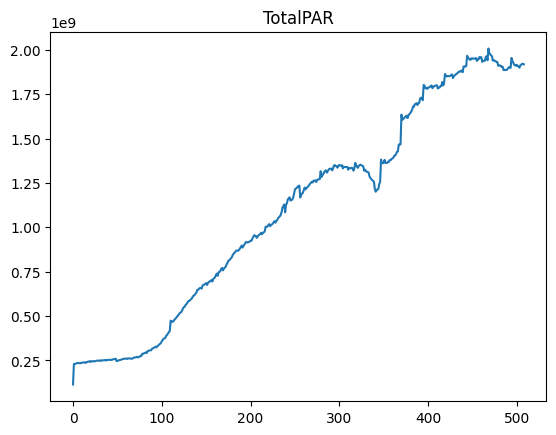

In [139]:
for i in data.columns:
  plt.plot(data[i])
  plt.title(i)
  plt.show()

In [140]:
data.columns

Index(['DATE', 'TotalCountOfAccounts', 'TotalPrincipalOutstanding',
       'TotalInterestOutstanding', 'TotalPrincipalOverdue',
       'TotalInterestOverdue', 'TotalPAR'],
      dtype='object')

In [141]:
columns = ['TotalCountOfAccounts', 'TotalPrincipalOutstanding',
       'TotalInterestOutstanding', 'TotalPrincipalOverdue',
       'TotalInterestOverdue']
values = data[columns].values

In [142]:
values.shape

(509, 5)

In [143]:
def scale_data(data):
    scaler = {}
    scaled_data = np.zeros_like(data, dtype=float)

    for i in range(data.shape[1]):
        scaler[i] = MinMaxScaler(feature_range=(-1, 1))
        scaled_data[:, i] = scaler[i].fit_transform(data[:, i].reshape(-1, 1)).flatten()

    return scaled_data, scaler

In [144]:
def inverse_transform(scaler, data):
  actual_data = np.zeros_like(data, dtype=float)
  for i in range(data.shape[1]):
    actual_data[:,i] = scaler[i].inverse_transform(data[:,i].reshape(-1,1)).flatten()
  return actual_data

In [151]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def scale_features_targets(X, y):
    """
    X: feature matrix (n_samples, n_features)
    y: target matrix (n_samples, n_targets)

    Returns:
        X_scaled, y_scaled, feature_scalers, target_scalers
    """
    n_features = X.shape[1]
    n_targets = y.shape[1]

    # Ensure float arrays
    X = X.astype(float)
    y = y.astype(float)

    # Scale features
    feature_scalers = {}
    X_scaled = np.zeros_like(X)
    for i in range(n_features):
        feature_scalers[i] = MinMaxScaler(feature_range=(-1, 1))
        X_scaled[:, i] = feature_scalers[i].fit_transform(X[:, i].reshape(-1, 1)).flatten()

    # Scale targets
    target_scalers = {}
    y_scaled = np.zeros_like(y)
    for i in range(n_targets):
        target_scalers[i] = MinMaxScaler(feature_range=(-1, 1))
        y_scaled[:, i] = target_scalers[i].fit_transform(y[:, i].reshape(-1, 1)).flatten()

    return X_scaled, y_scaled, feature_scalers, target_scalers


def inverse_transform_targets(y_scaled, target_scalers):
    """
    y_scaled: scaled target array
    target_scalers: dictionary of scalers for each target
    """
    n_targets = y_scaled.shape[1]
    y_actual = np.zeros_like(y_scaled, dtype=float)

    for i in range(n_targets):
        y_actual[:, i] = target_scalers[i].inverse_transform(y_scaled[:, i].reshape(-1, 1)).flatten()

    return y_actual

In [145]:
def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

In [149]:
window = 15
X, y = create_sequences(values, window)
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (494, 15, 5)
y shape: (494, 5)


In [150]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [105]:
scaled_data, scaler = scale_data(values)

In [148]:
print(x_train.shape[1])
print(x_train.shape[2])

15
5


In [129]:
def train_model(x_train, y_train, x_test, y_test, epochs=50):
  lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(200, return_sequences=True ,input_shape=(x_train.shape[1],x_train.shape[2])),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(5)
  ])

  lstm_model.compile(optimizer= tf.keras.optimizers.Adam(),
                    loss = tf.keras.losses.MeanSquaredError(),
                    metrics = [tf.keras.metrics.MeanAbsoluteError()])

  lstm_model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

  return lstm_model

In [130]:
def predict_model(model, x_test, y_test):
    lstm_y_pred_scaled = model.predict(x_test)
    lstm_y_pred = inverse_transform(scaler,lstm_y_pred_scaled)
    y_test_actual = inverse_transform(scaler, y_test)
    print(mean_squared_error(lstm_y_pred, y_test_actual))
    print(mean_absolute_error(lstm_y_pred, y_test_actual))
    return lstm_y_pred, lstm_y_pred_scaled, y_test_actual

In [133]:
model = train_model(x_train, y_train, x_test, y_test, epochs=50)
y_pred, y_hat, y_actual = predict_model(model, x_test, y_test)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - loss: 0.1598 - mean_absolute_error: 0.3061 - val_loss: 0.0575 - val_mean_absolute_error: 0.2037
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0135 - mean_absolute_error: 0.0841 - val_loss: 0.0356 - val_mean_absolute_error: 0.1690
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 0.0031 - mean_absolute_error: 0.0423 - val_loss: 0.0259 - val_mean_absolute_error: 0.1308
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0018 - mean_absolute_error: 0.0320 - val_loss: 0.0252 - val_mean_absolute_error: 0.1194
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0015 - mean_absolute_error: 0.0273 - val_loss: 0.0215 - val_mean_absolute_error: 0.1212
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0016 - mean_absolute_error: 0.0285 - val_loss: 0.0207 - val_mean_absolute_error: 0.1103
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0013 - mean_absolute_error: 0.0254 - val_lo

MAE : 1318.009627525251 Percentage : 2.0


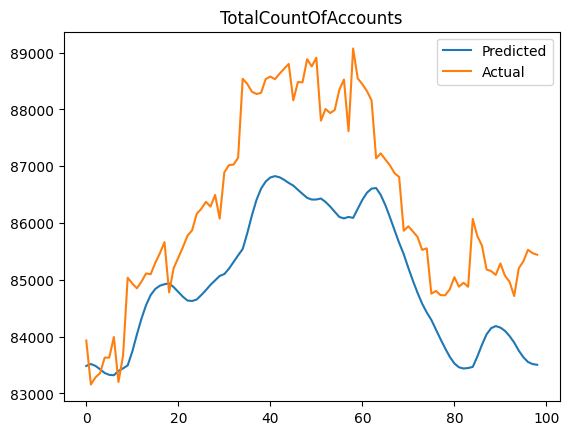

MAE : 57377588.424242385 Percentage : 5.0


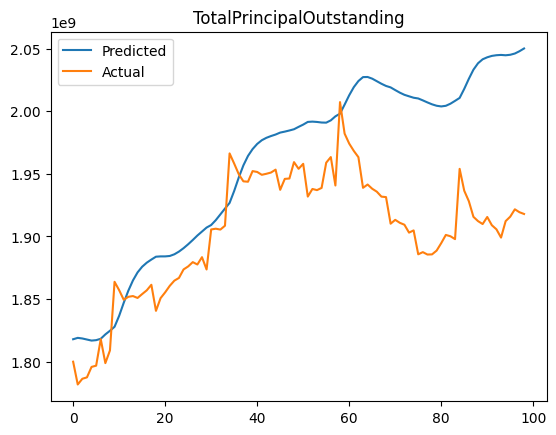

MAE : 3621176.1414141413 Percentage : 2.0


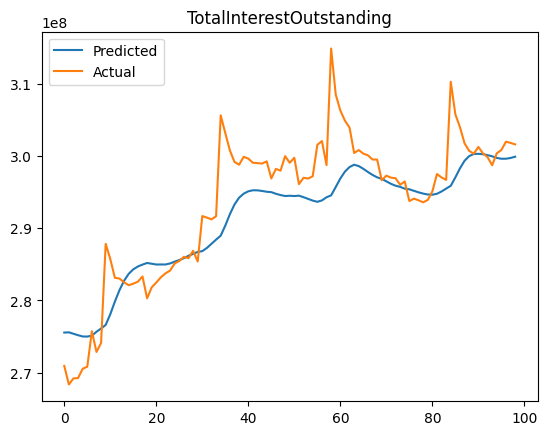

MAE : 89004468.97979797 Percentage : 15.0


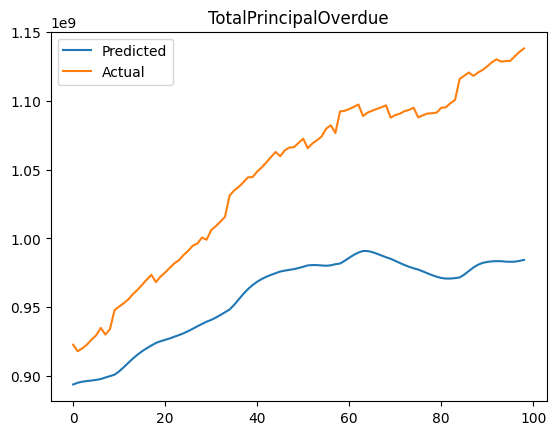

MAE : 17426519.08080808 Percentage : 21.0


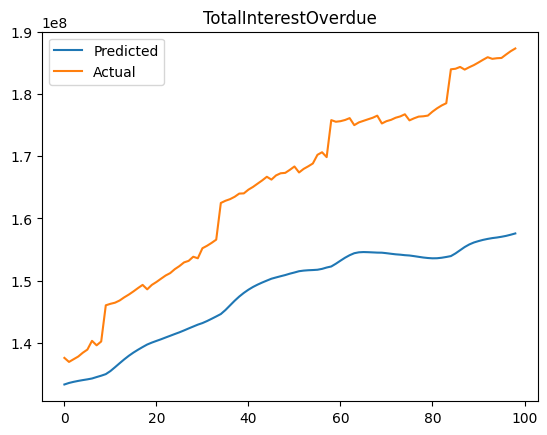

In [134]:
import warnings
warnings.filterwarnings
for i in range(y.shape[1]):
  mae= mean_absolute_error(y_pred[:,i],y_actual[:,i])
  plt.plot(y_pred[:,i], label='Predicted')
  plt.plot(y_actual[:,i], label='Actual')
  print(f'MAE : {mae} Percentage : {np.round(np.multiply(mae / data.mean()[i+1], 100))}')
  plt.title(columns[i])
  plt.legend()
  plt.show()